In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from datetime import datetime
from tqdm import tqdm
print(f'Current Step #01 [now = {datetime.now()}')


Current Step #01 [now = 2025-06-20 18:03:15.963728


In [7]:
results = {}

In [8]:
def load_metrics(random_state, version, db_file_path):
    query = f'select rounds, matched_cnts from rndforest where random_state={random_state} and version=\\"{version}\\"'
    metrics = !echo {query} | sqlite3 {db_file_path}
    metrics = metrics[0].split('|')
    return metrics[0], metrics[1]


def load_data(version="T_01_10", db_file_path='../db/metrics.db', random_state=113789):
    rounds_str, matched_cnts_str = load_metrics(random_state=random_state, db_file_path=db_file_path, version=version)
    rounds = []
    matched_cnts = []
    for i in rounds_str.split(','):
        rounds.append(int(i))
    for i in matched_cnts_str.split(','):
        matched_cnts.append(int(i))
    rounds.reverse()
    matched_cnts.reverse()
    df = pd.DataFrame(zip(rounds, matched_cnts), columns=['rounds', 'matched_cnts'])
    return df


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [9]:
time_steps = 10
data_dim = 1
num_samples = 100
X = np.random.rand(num_samples, time_steps, data_dim)
print(len(X))

100


```python
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout,  Dense
from tensorflow.keras.regularizers import l1_l2, l2

total_words = 478
max_sequence_len = 90
model = Sequential()
Layer1 = model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
Layer2 = model.add(Bidirectional(LSTM(20, return_sequences=True)))
Layer3 = model.add(Dropout(.03))
Layer4 = model.add(LSTM(20))
Layer5 = model.add(Dense(total_words, 
    kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=l2(1e-4),
    activity_regularizer=l2(1e-5)))
          # A Dense Layer including regularizers
Layer6 = model.add(Dense(total_words, activation = 'softmax'))
          
# Pick an optimizer
          
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()
```

In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Example data
data = np.array([[1], [2], [3], [4], [5]])

# Initialize and fit-transform the scaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

print("Scaled Data:")
print(scaled_data)

new_scaled = np.array([0.33, 0.5, 0.83456, 0.845])
new_scaled = new_scaled.reshape(-1, 1)

# Restore the original data using inverse_transform
restored_data = scaler.inverse_transform(scaled_data)
restored_data1 = scaler.inverse_transform(new_scaled)
print("\nRestored Data:")
print(restored_data)
print(restored_data1)


Scaled Data:
[[0.  ]
 [0.25]
 [0.5 ]
 [0.75]
 [1.  ]]

Restored Data:
[[1.]
 [2.]
 [3.]
 [4.]
 [5.]]
[[2.32   ]
 [3.     ]
 [4.33824]
 [4.38   ]]


In [11]:
from enum import Enum


class PrivateScaler:
    def __init__(self, divider=6.0):
        """" __init___ """
        self._divider = divider
        self.p_max = 1
        self.p_min = 0

    def fit_transform(self, data):
        """ fit_transform """
        self.p_max = data.max() + 1
        self._divider = self.p_max
        scaled_data = np.array([[round(float(i[0])/self._divider, 9)] for i in data])
        return scaled_data

    def inverse_transform(self, data):
        """ inverse_transform """
        self.p_min = data.min()
        if len(data) > 1:
            restored = np.array([[((i[0] - self.p_min)*self._divider)] for i in data])
            r_max = restored.max()
            while r_max < 0.1:
                restored *= 10
                r_max = restored.max()
        else:
            restored = np.array([[((i[0])*self._divider)] for i in data])
        return restored


class ScalerType(Enum):
    PRIVATE=0,
    STANDARD=1,
    MIN_MAX=2


scaler_cls = {
    ScalerType.PRIVATE: PrivateScaler,
    ScalerType.STANDARD: StandardScaler,
    ScalerType.MIN_MAX: MinMaxScaler # feature_range=(0,1)
    }


class DataScaling():
    def __init__(self, scaler_type: ScalerType, *args: list):
        self._scaler_type = scaler_type
        self._scaler_cls = scaler_cls[scaler_type](*args)

    def fit_transform(self, data):
        return self._scaler_cls.fit_transform(data)

    def inverse_transform(self, datas: list):
        inversed_data = []
        if self._scaler_type == ScalerType.PRIVATE:
            for data in datas:
                if data[1] == True:
                    inversed = self._scaler_cls.inverse_transform(data[0].reshape(-1, 1))
                else:
                    inversed = self._scaler_cls.inverse_transform(data[0])
                inversed_data.append(inversed)
        else:
            cnt = 1
            for data in datas:
                print(f'cnt = {cnt}')
                cnt += 1
                if data[1] == True:
                    inversed = self._scaler_cls.inverse_transform(data[0].reshape(-1, 1))
                else:
                    inversed = self._scaler_cls.inverse_transform(data[0])
                inversed_data.append(inversed)
        return inversed_data


### 최종 결과 입니다.
def analyze_v1(random_state,
               version,
               db_file_path,
               predict_round=7,
               predict_scale=10000000,
               scaler_type=ScalerType.PRIVATE,
               layer_count=3,
               activation='sigmoid',
               units=50,
               draw_graph=True,
               verbose=0):
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense

    # 1. Prepare the Data
    # Create sample time series data
    df = load_data(version=version, db_file_path=db_file_path, random_state=random_state)
    if verbose > 0:
        print('df', df)
    if verbose > 0:
        print(f'Current Step #02 [now = {datetime.now()}]')

    data = df['matched_cnts'].values.reshape(-1, 1)

    # Normalize the data
    scaler = DataScaling(scaler_type)
    scaled_data = scaler.fit_transform(data)
    if verbose > 0:
        print(f'Current Step #04 [now = {datetime.now()}]')

    # Define sequence length (timesteps)
    sequence_length = 10

    # Create sequences for training
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i + sequence_length, 0])
        y.append(scaled_data[i + sequence_length, 0])
    X, y = np.array(X), np.array(y)
    if verbose > 0:
        print(f'Current Step #06 [now = {datetime.now()}]')

    # Reshape X for LSTM input (samples, timesteps, features)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    if verbose > 0:
        print(f'Current Step #08 [now = {datetime.now()}]')

    # Split data into training and testing sets
    # train_size = int(len(X) * 0.8)
    train_size = int(len(X) * 0.9)

    X_train, X_test, X_last = X[:train_size], X[train_size:], np.array([[y[-1:]]])
    y_train, y_test = y[:train_size], y[train_size:]
    if verbose > 0:
        print(f'Current Step #10 [now = {datetime.now()}]')

    tf.random.set_seed(random_state)

    # 2. Build the LSTM Model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    # model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    for i in range(layer_count):
        model.add(LSTM(units=units, return_sequences=True, activation=activation))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(units=1)) # Output layer for predicting a single value
    if verbose > 0:
        print(f'Current Step #12 [now = {datetime.now()}]')

    # 3. Compile and Train the Model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0) # verbose=0 for silent training

    if verbose > 0:
        print(f'Current Step #14 [now = {datetime.now()}]')

    # 4. Make Predictions
    train_predict = model.predict(X_train, verbose=verbose)
    test_predict = model.predict(X_test, verbose=verbose)
    last_predict = model.predict(X_last, verbose=verbose)
    if verbose > 0:
        print(f'Current Step #16 [now = {datetime.now()}]')

    # Inverse transform predictions to original scale
    scaled_data1 = scaled_data
    wanted_datas = [(train_predict, False),
                    (test_predict, False),
                    (last_predict, True),
                    (y_train, True),
                    (y_test, True),
                    (scaled_data, False)]
    inversed_datas = scaler.inverse_transform(wanted_datas)
    train_predict = inversed_datas[0]
    test_predict = inversed_datas[1]
    last_predict = inversed_datas[2]
    y_train_original = inversed_datas[3]
    y_test_original = inversed_datas[4]
    scaled_data = inversed_datas[5]

    if verbose > 0:
        print(f'Current Step #18 [now = {datetime.now()}]')

    # 5. Evaluate the Model (Optional, but recommended)
    from sklearn.metrics import mean_squared_error
    train_rmse = np.sqrt(mean_squared_error(y_train_original, train_predict))
    test_rmse = np.sqrt(mean_squared_error(y_test_original, test_predict))

    if verbose > 0:
        print(f'Current Step #20 [now = {datetime.now()}]')
        print(f"Train RMSE: {train_rmse}")
        print(f"Test RMSE: {test_rmse}")
        print(f'random_state = {random_state}')
        print(f'last_prediction = {last_predict}')
        print(f'data_max_val = {scaled_data.max()}')
    # You can also visualize the results
    if draw_graph:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 6))
        plt.plot(scaled_data1, label='Original Data')
        plt.plot(np.arange(sequence_length,
                           sequence_length + len(train_predict)),
                 train_predict,
                 label='Train Predictions')
        plt.plot(np.arange(sequence_length + len(train_predict),
                           sequence_length + len(train_predict) + len(test_predict)),
                 test_predict,
                 label='Test Predictions')
        plt.plot(np.arange(sequence_length + len(train_predict) + len(test_predict),
                       sequence_length + len(train_predict) + len(test_predict) + len(last_predict)),
                 last_predict,
                 label='Last Predictions')
        plt.xlabel(f'{random_state}\'s Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
    return scaled_data.max(), last_predict, random_state


print(f'Current work : {datetime.now()}')

Current work : 2025-06-20 18:03:18.198587


In [12]:
version = "T_01_11"
db_file_path = '../db/metrics.db'
random_state = 113708
predict_scale = 10000000
predict_round = 8
scaler_type=ScalerType.PRIVATE
# layer information
layer_count = 3
activation = 'sigmoid'
units = 50

analyze_v1(random_state=random_state,
           version=version,
           predict_round=predict_round,
           db_file_path=db_file_path,
           scaler_type=scaler_type,
           layer_count=layer_count,
           activation=activation,
           units=units,
           verbose=0)

KeyboardInterrupt: 

Current Step #02 [now = 2025-06-20 15:25:31.521138]
Current Step #04 [now = 2025-06-20 15:25:31.524006]
Current Step #06 [now = 2025-06-20 15:25:31.524384]
Current Step #08 [now = 2025-06-20 15:25:31.524408]
Current Step #10 [now = 2025-06-20 15:25:31.524425]
Current Step #12 [now = 2025-06-20 15:25:31.600531]
Current Step #14 [now = 2025-06-20 15:26:38.634415]
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Current Step #16 [now = 2025-06-20 15:26:39.532459]
cnt = 1
cnt = 2
cnt = 3
cnt = 4
cnt = 5
cnt = 6
Current Step #18 [now = 2025-06-20 15:26:39.534310]
Current Step #20 [now = 2025-06-20 15:26:39.534902]
Train RMSE: 0.9319965915588775
Test RMSE: 0.9437824529695342
random_state = 113789
last_prediction = [[1.11430156]]
data_max_val = 3.0


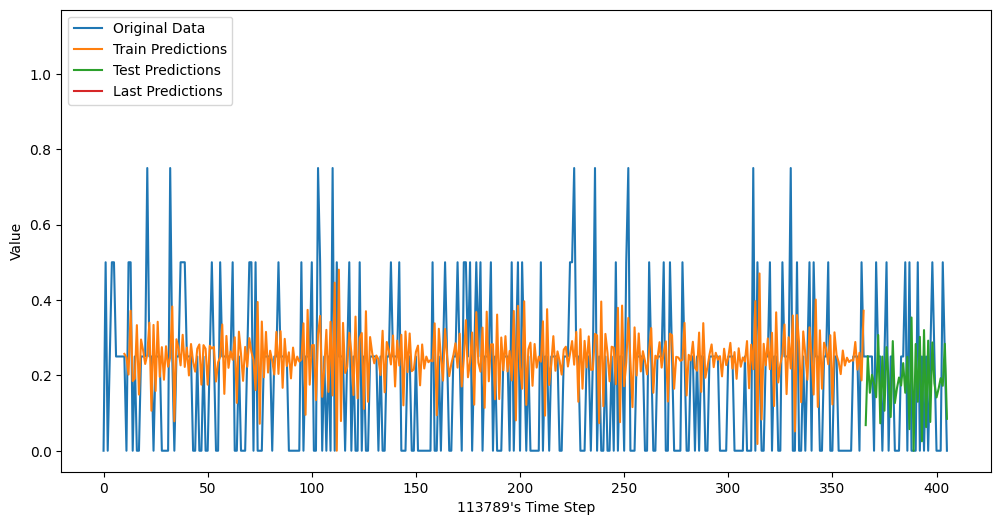

In [194]:
version = "T_01_11"
db_file_path = '../db/metrics.db'
random_state = 113799
# predict_scale = 10000000
predict_scale = 1000000
predict_round = 7
scaler_type=ScalerType.PRIVATE
# layer information
layer_count = 3
activation = 'sigmoid'
units = 50
analyze_v1(random_state=random_state, version=version, db_file_path=db_file_path, verbose=0)

Current Step #02 [now = 2025-06-20 15:05:16.255729]
Current Step #04 [now = 2025-06-20 15:05:16.258631]
Current Step #06 [now = 2025-06-20 15:05:16.259020]
Current Step #08 [now = 2025-06-20 15:05:16.259052]
Current Step #10 [now = 2025-06-20 15:05:16.259069]
Current Step #12 [now = 2025-06-20 15:05:16.338968]
Current Step #14 [now = 2025-06-20 15:06:26.817272]
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Current Step #16 [now = 2025-06-20 15:06:27.664470]
cnt = 1
cnt = 2
cnt = 3
cnt = 4
cnt = 5
cnt = 6
Current Step #18 [now = 2025-06-20 15:06:27.666416]
Current Step #20 [now = 2025-06-20 15:06:27.667357]
Train RMSE: 1.0499059937410558
Test RMSE: 1.0196612751814165
random_state = 113789
last_prediction = [[0.58948039]]


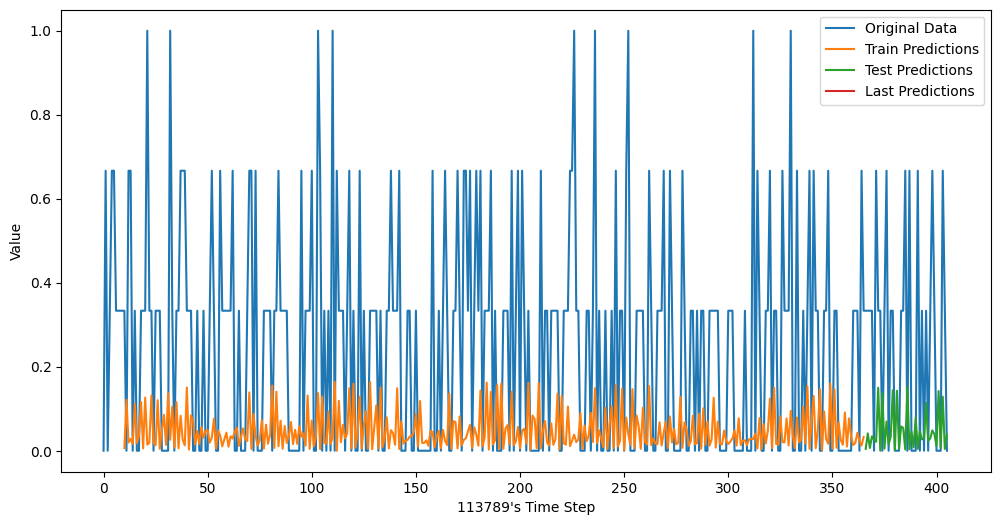

In [170]:
### 최종 결과 입니다. (113789)
version = "T_01_11"
db_file_path = '../db/metrics.db'
random_state = 113789
predict_scale = 10000000
predict_round = 7
scaler_type=ScalerType.PRIVATE
# layer information
layer_count = 3
activation = 'sigmoid'
units = 50
analyze_v1(random_state=random_state,
           version=version,
           predict_round=predict_round,
           db_file_path=db_file_path,
           scaler_type=scaler_type,
           layer_count=layer_count,
           activation=activation,
           units=units,
           verbose=0)

Current Step #02 [now = 2025-06-20 15:11:20.793368]
Current Step #04 [now = 2025-06-20 15:11:20.795996]
Current Step #06 [now = 2025-06-20 15:11:20.796451]
Current Step #08 [now = 2025-06-20 15:11:20.796489]
Current Step #10 [now = 2025-06-20 15:11:20.796533]
Current Step #12 [now = 2025-06-20 15:11:20.975319]
Current Step #14 [now = 2025-06-20 15:12:30.503706]
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
Current Step #16 [now = 2025-06-20 15:12:31.451170]
cnt = 1
cnt = 2
cnt = 3
cnt = 4
cnt = 5
cnt = 6
Current Step #18 [now = 2025-06-20 15:12:31.453186]
Current Step #20 [now = 2025-06-20 15:12:31.453907]
Train RMSE: 1.0416409373732143
Test RMSE: 1.0159777512602295
random_state = 113789
last_prediction = [[0.99832758]]
data_max_val = 3.0


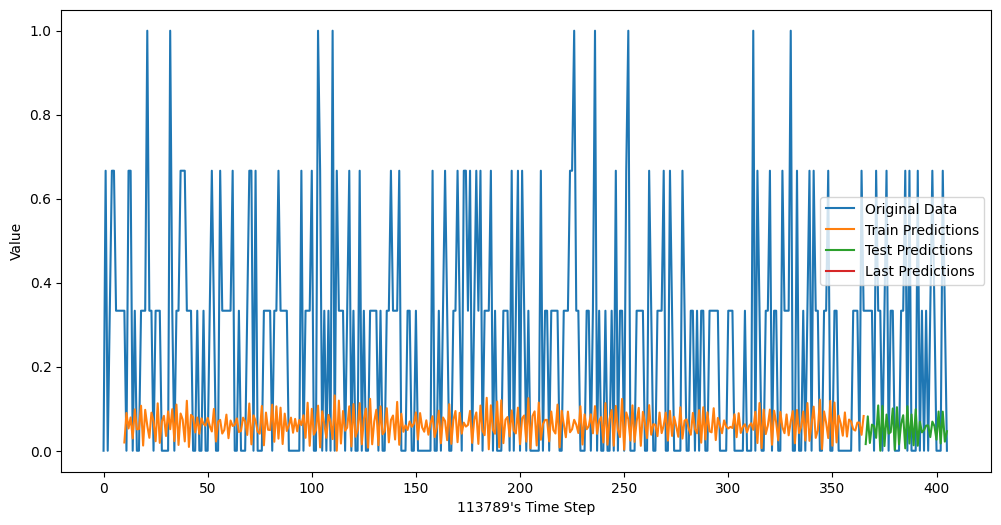

In [187]:
### 최종 결과 입니다. (113789)
version = "T_01_11"
db_file_path = '../db/metrics.db'
random_state = 113700
predict_scale = 10000000
predict_round = 7
layer_count = 3
activation = 'sigmoid'
units = 50
scaler_type=ScalerType.PRIVATE
analyze_v1(random_state=random_state,
           version=version,
           predict_round=predict_round,
           db_file_path=db_file_path,
           scaler_type=scaler_type,
           layer_count=layer_count,
           activation=activation,
           units=units,
           verbose=0)

Current Step #02 [now = 2025-06-20 15:14:07.960355]
Current Step #04 [now = 2025-06-20 15:14:07.962936]
Current Step #06 [now = 2025-06-20 15:14:07.963274]
Current Step #08 [now = 2025-06-20 15:14:07.963295]
Current Step #10 [now = 2025-06-20 15:14:07.963311]
Current Step #12 [now = 2025-06-20 15:14:08.061781]
Current Step #14 [now = 2025-06-20 15:15:17.195733]
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
Current Step #16 [now = 2025-06-20 15:15:18.137562]
cnt = 1
cnt = 2
cnt = 3
cnt = 4
cnt = 5
cnt = 6
Current Step #18 [now = 2025-06-20 15:15:18.139677]
Current Step #20 [now = 2025-06-20 15:15:18.140870]
Train RMSE: 1.0142249625717537
Test RMSE: 0.9945376567519973
random_state = 113789
last_prediction = [[0.4766673]]
data_max_val = 3.0


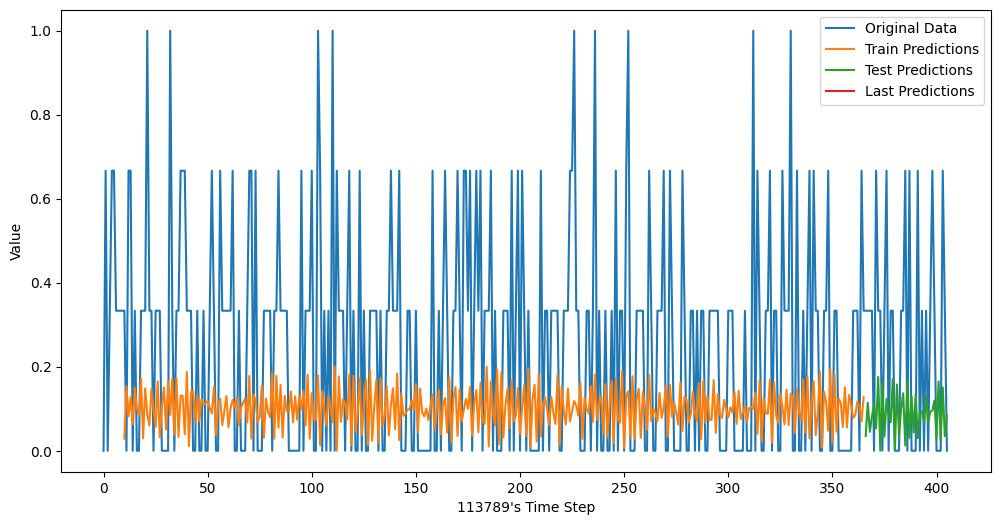

In [188]:
version = "T_01_11"
db_file_path = '../db/metrics.db'
random_state = 113705
# predict_scale = 10000000
predict_scale = 1000000
predict_round = 7
layer_count = 3
activation = 'sigmoid'
units = 50
scaler_type=ScalerType.PRIVATE
analyze_v1(random_state=random_state,
           version=version,
           predict_round=predict_round,
           db_file_path=db_file_path,
           scaler_type=scaler_type,
           layer_count=layer_count,
           activation=activation,
           units=units,
           verbose=0)

In [13]:
"""
version TEXT, random_state INTEGER, possibility FLOAT, max INTEGER
"""
def insert_possi(version, max, possi, random_state):
    table_name='rndforest_possi'
    db_file_path='../db/metrics.db'
    sql = f'insert into {table_name} (version, random_state, possibility, max) values(\\"{version}\\", {random_state}, {possi}, {max});'
    !echo "{sql}" | sqlite3 {db_file_path}

print(f'Current Step : [now {datetime.now()}]')

Current Step : [now 2025-06-20 18:03:36.349355]


In [16]:
results=[]
version = "T_01_11"
db_file_path = '../db/metrics.db'
#113450에서 10씩증가
# random_state_begin = 113400
random_state_begin = 113450
gap=10
# predict_scale = 10000000
predict_scale = 1000000
predict_round = 7
layer_count = 3
activation = 'sigmoid'
units = 50
scaler_type=ScalerType.PRIVATE
for random_state in tqdm(range(random_state_begin, random_state_begin+gap)):
    scaled_data_max, last_predict, random_state = analyze_v1(random_state=random_state,
                                                             version=version,
                                                             predict_round=predict_round,
                                                             db_file_path=db_file_path,
                                                             scaler_type=scaler_type,
                                                             layer_count=layer_count,
                                                             activation=activation,
                                                             units=units,
                                                             draw_graph=False,
                                                             verbose=0)
    results.append((scaled_data_max, last_predict, random_state))
    if last_predict > 1.7:
        print(scaled_data_max, last_predict, random_state)
    

 70%|███████   | 7/10 [09:34<04:06, 82.07s/it]


IndexError: list index out of range

In [17]:
for result in results:
    print(result)
    insert_possi(version=version, max=result[0], possi=result[1][0][0], random_state=result[2])

(np.float64(3.0), array([[0.92457706]]), 113450)
(np.float64(4.0), array([[0.87654367]]), 113451)
(np.float64(4.0), array([[0.96808255]]), 113452)
(np.float64(3.0), array([[0.62320232]]), 113453)
(np.float64(4.999999998), array([[0.92815804]]), 113454)
(np.float64(3.0), array([[1.05252194]]), 113455)
(np.float64(4.0), array([[0.67466877]]), 113456)


In [ ]:

actual_numbers = [
    [1175, 3, 4, 6, 8, 32, 42],
    [1174, 8, 11, 14, 17, 36, 39],
    [1173, 1, 5, 18, 20, 30, 35],
    [1172, 7, 9, 24, 40, 42, 44],
    [1171, 3, 6, 7, 11, 12, 17],
    [1170, 3, 13, 28, 34, 38, 42],
    [1169, 5, 12, 24, 26, 39, 42],
    [1168, 9, 21, 24, 30, 33, 37],
    [1167, 8, 23, 31, 35, 39, 40],
]

In [ ]:
4.0 [[2.05857292]] 113410
4.0 [[1.74410105]] 113424
4.0 [[2.01577738]] 113429